In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import os
import re
import numpy as np
import seaborn
import tensorflow as tf
import datetime

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, precision_score

%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def projection_on_set(vector, set_of_vectors):
    projection_vector = np.zeros(*vector.shape) 
    for ort_vector in set_of_vectors:
        projection_vector += np.dot(vector, ort_vector) / np.linalg.norm(ort_vector) * ort_vector
    return projection_vector

In [6]:
import AnonymousWalkEmbeddings, AnonymousWalkKernel

In [7]:
reload(AnonymousWalkEmbeddings)

<module 'AnonymousWalkEmbeddings' from 'AnonymousWalkEmbeddings.pyc'>

In [8]:
reload(AnonymousWalkKernel)

<module 'AnonymousWalkKernel' from 'AnonymousWalkKernel.pyc'>

# Детектирование аномалий в потоках графов 

## Описание 

В этом блоке будем сравнивать алгоритмы, которые могут выделять аномальные элементы в потоках графов.
Для сравнения будем использовать алгоритмы [ParCube](#parcube), [DeltaCon](#deltacon), [Concept Drift and Anomaly Detection in Graph Streams](#cdadgs) и [наш](#ref) алгоритм

Будем проводить эксперименты на датасете [TwitterSecurity2014](http://odds.cs.stonybrook.edu/twittersecurity-dataset/)
* количество нод ~ 130 к
* количество таймстемпов ~ 120 
* 20 аномальных дней 

Сам датасет состоит из строк вида: user_1 user_2 number_of_co-mentions

В качестве метрики для сравнения будем считать precision/recall 


<a id='parcube'></a>

## ParCube

<a id='deltacon'></a>

## DeltaCon

<a id='cdadgs'>

## Concept Drift and Anomaly Detection in Graph Streams

<a id='ref'></a>

## Reference 

Сначала пробмуем поучить модель с такими же параметрами, как на MUTAG из туториала

In [63]:
dataset = 'relabeled_graphs'

batch_size = 100
window_size = 6
embedding_size_w = 64
embedding_size_d = 64
num_samples = 32

concat = False
loss_type = 'sampled_softmax'
optimize = 'Adagrad'
learning_rate = 1.0
root = '../twitter_security_2014/'
ext = 'graphml'
steps = 5
epochs = 10
batches_per_epoch = 3
candidate_func = None
graph_labels = None

model = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  embedding_size_w = embedding_size_w, embedding_size_d = embedding_size_d,
                  num_samples = num_samples, concat = concat, loss_type = loss_type,
                  optimize = optimize, learning_rate = learning_rate, root = root,
                  ext = ext, steps = steps, epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model.train()

Number of graphs: 80
Number of words: 52
Initialized
Epoch: 0
Graph 0: 47 nodes
Time: 0.84453701973
Graph 1: 936 nodes
Graph 2: 5482 nodes
Graph 3: 3148 nodes
Graph 4: 6329 nodes
Graph 5: 4003 nodes
Graph 6: 2112 nodes
Graph 7: 3231 nodes
Graph 8: 4717 nodes
Graph 9: 3769 nodes
Graph 10: 5462 nodes
Time: 2.78222417831
Graph 11: 4641 nodes
Graph 12: 5682 nodes
Graph 13: 6341 nodes
Graph 14: 6022 nodes
Graph 15: 5762 nodes
Graph 16: 5423 nodes
Graph 17: 5324 nodes
Graph 18: 5146 nodes
Graph 19: 5459 nodes
Graph 20: 5552 nodes
Time: 1.83579015732
Graph 21: 5687 nodes
Graph 22: 5592 nodes
Graph 23: 5795 nodes
Graph 24: 5084 nodes
Graph 25: 6035 nodes
Graph 26: 5500 nodes
Graph 27: 5843 nodes
Graph 28: 5928 nodes
Graph 29: 4824 nodes
Graph 30: 6197 nodes
Time: 2.6672000885
Graph 31: 5555 nodes
Graph 32: 4852 nodes
Graph 33: 6275 nodes
Average loss at step 100: 4941.579623
Graph 34: 6428 nodes
Graph 35: 6119 nodes
Graph 36: 5771 nodes
Graph 37: 6720 nodes
Graph 38: 5162 nodes
Graph 39: 5309 

Подгрузим разметку для графов 

In [64]:
labels = open('../twitter_security_2014/relabeled_graphs/labels.txt')
labels = labels.read()
labels = np.array(map(lambda x: int(x), labels.split()))

### PCA approximation
Здесь пробуем построить для части графов pca и потом посчитать проекции следующих эмбедингов на полученные направления. Нас интересует, как хорошо полученные проекции могут аппроксимировать сами эмбединги.

Видим, что аутлаеры не особо выбиваются из общего паттерна. Дальше попробуем посмотреть, чем можно такое поведение объяснить. 

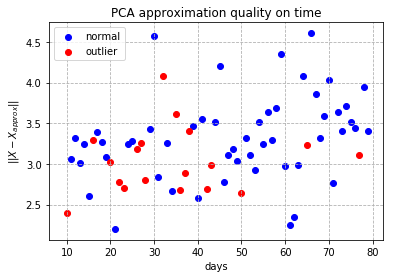

In [65]:
pca_comp_number = 10

test_set = model.graph_embeddings[:pca_comp_number]

pca = PCA(n_components=10)
pca.fit(scale(test_set))

projection_set = pca.components_[:]

res = []
for embedding in model.graph_embeddings[pca_comp_number:]:
    proj = projection_on_set(embedding, projection_set)
    res.append(np.linalg.norm(embedding - proj))
res = np.array(res)

fig = plt.figure()
plt.scatter(np.where(labels[pca_comp_number:] == 0)[0]+pca_comp_number, 
            res[np.where(labels[pca_comp_number:] == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels[pca_comp_number:] == 1)[0]+pca_comp_number, 
            res[np.where(labels[pca_comp_number:] == 1)[0]], label='outlier', c='r')
plt.xlabel("days")
plt.ylabel("$||X - X_{approx}||$")
plt.title("PCA approximation quality on time")
plt.legend()
plt.grid(ls='dashed')
#fig.savefig('graph_series_without_norm.pdf', format='pdf')

### Norm differences 

Посмотрим, как меняются векторы эмбедингов от времени. Для этого, например, можно порисовать норму разностей двух последующих векторов. Как видно из графиков какой-то хорошей шшеометрической структуры пока не получили.

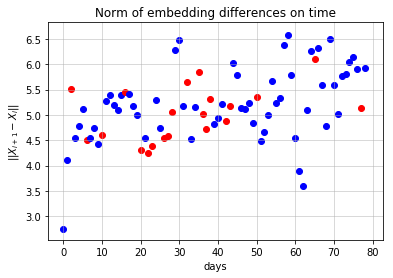

In [66]:
fig = plt.figure()
for i, label in zip(range(len(labels[:-1])), labels[:-1]):
    if label == 0:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i+1] - model.graph_embeddings[i]), c='b')
    else:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i+1] - model.graph_embeddings[i]), c='r')
    
plt.xlabel('days')
plt.ylabel('$||X_{i+1} - X_{i}||$')
plt.title("Norm of embedding differences on time")
plt.grid(alpha=0.6)
#fig.savefig('difference_embedding.pdf', format='pdf')

### Norm series 

Есть предположение о том, что аутлаеры сильно будут отличаться по норме от обычных векторов. Построим график зависимости норм векторов от времени. Получаем, что мало того, что аутлаеры не выбиваются из общей кучи, так еще необычное поведение с ростом нормы эмбедингов. Дальше попробуем разобраться, чем оно вызвано.

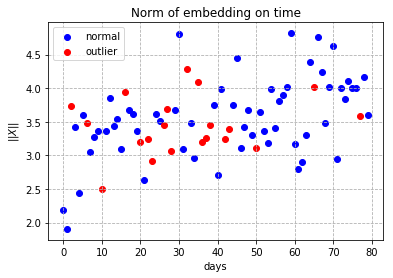

In [67]:
fig = plt.figure()
norms = np.linalg.norm(model.graph_embeddings, axis=1)

plt.scatter(np.where(labels == 0)[0], norms[np.where(labels == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels == 1)[0], norms[np.where(labels == 1)[0]], label='outlier', c='r')

plt.xlabel("days")
plt.ylabel("$||X||$")
plt.title("Norm of embedding on time")

plt.legend()
plt.grid(ls='dashed')
#fig.savefig('norms_series.pdf', format='pdf')

### Norm growth

Попробуем более отдельно рассмотреть вопрос с прошлого пункта. Интерсно, чем конкретно вызвано такое поведение у эмбедингов: либо это специфика модели, либо датасета. 

Чтобы проверить это предположение попробуем случайно помешать первые графы при обучении и снова отрисовать графики зависимости нормы от времени.

Получаем, что на самом деле такой вид графика не зависит от датасета, а относится к самой модели. Плюс к этому, вид графика завист от парметра batches_per_epoch. Чем он больше, тем более гладким получается график. При совсем мелких значениях такая зависимость нормы от времени пропадает. 

In [165]:
dataset = 'relabeled_graphs'

batch_size = 100
window_size = 10
embedding_size_w = 64
embedding_size_d = 3
num_samples = 32

concat = False
loss_type = 'sampled_softmax'
optimize = 'Adagrad'
learning_rate = 1.0
root = '../twitter_security_2014/'
ext = 'graphml'
steps = 7
epochs = 2
batches_per_epoch = 10
candidate_func = None
graph_labels = None

model2 = AnonymousWalkEmbeddings.AWE(dataset = dataset, batch_size = batch_size, window_size = window_size,
                  embedding_size_w = embedding_size_w, embedding_size_d = embedding_size_d,
                  num_samples = num_samples, concat = concat, loss_type = loss_type,
                  optimize = optimize, learning_rate = learning_rate, root = root,
                  ext = ext, steps = steps, epochs = epochs, batches_per_epoch = batches_per_epoch,
                  candidate_func = candidate_func, graph_labels=graph_labels)

model2.train()

Number of graphs: 80
Number of words: 877
Initialized
Epoch: 0
Graph 0: 47 nodes
Time: 2.4467279911
Graph 1: 936 nodes
Graph 2: 5482 nodes
Graph 3: 3148 nodes
Graph 4: 6329 nodes
Graph 5: 4003 nodes
Graph 6: 2112 nodes
Graph 7: 3231 nodes
Graph 8: 4717 nodes
Graph 9: 3769 nodes
Average loss at step 100: 8144.639649
Graph 10: 5462 nodes
Time: 6.48454904556
Graph 11: 4641 nodes
Graph 12: 5682 nodes
Graph 13: 6341 nodes
Graph 14: 6022 nodes
Graph 15: 5762 nodes
Graph 16: 5423 nodes
Graph 17: 5324 nodes
Graph 18: 5146 nodes
Graph 19: 5459 nodes
Average loss at step 200: 5850.941647
Graph 20: 5552 nodes
Time: 4.28212809563
Graph 21: 5687 nodes
Graph 22: 5592 nodes
Graph 23: 5795 nodes
Graph 24: 5084 nodes
Graph 25: 6035 nodes
Graph 26: 5500 nodes
Graph 27: 5843 nodes
Graph 28: 5928 nodes
Graph 29: 4824 nodes
Average loss at step 300: 4673.135439
Graph 30: 6197 nodes
Time: 7.76495599747
Graph 31: 5555 nodes
Graph 32: 4852 nodes
Graph 33: 6275 nodes
Graph 34: 6428 nodes
Graph 35: 6119 nodes
G

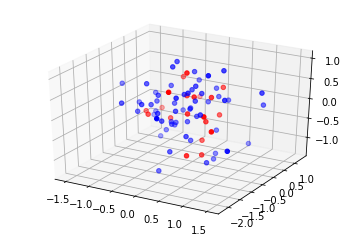

In [168]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_0 = model2.graph_embeddings[np.where(labels == 0)]
x_1 = model2.graph_embeddings[np.where(labels == 1)]

ax.scatter(x_0[:, 0], x_0[:, 1], x_0[:, 2], c='b')
ax.scatter(x_1[:, 0], x_1[:, 1], x_1[:, 2], c='r')
plt.show()

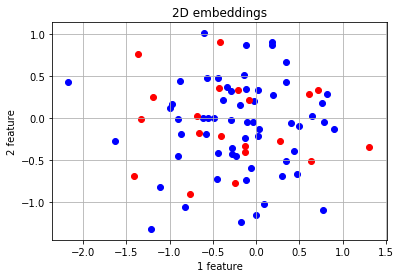

In [178]:
fig = plt.figure()

x_0 = model2.graph_embeddings[np.where(labels == 0)]
x_1 = model2.graph_embeddings[np.where(labels == 1)]

plt.scatter(x_0[:, 1], x_0[:, 2], c='b')
plt.scatter(x_1[:, 1], x_1[:, 2], c='r')
plt.title("2D embeddings")
plt.xlabel('1 feature')
plt.ylabel('2 feature')
plt.grid()
plt.show()

fig.savefig('2d_embeddings.pdf', format='pdf')

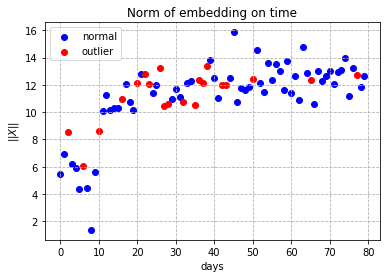

In [29]:
shuffles = ['timestep_3.graphml', 'timestep_7.graphml', 'timestep_9.graphml',
            'timestep_4.graphml', 'timestep_8.graphml', 'timestep_1.graphml', 
            'timestep_5.graphml', 'timestep_2.graphml', 'timestep_0.graphml', 
            'timestep_6.graphml']

shuffles = map(lambda x: int(x[:-8].split('_')[1]), shuffles)

fig = plt.figure()
right_order_ge = np.concatenate((model2.graph_embeddings[shuffles], model2.graph_embeddings[10:]))
norms = np.linalg.norm(right_order_ge, axis=1)

plt.scatter(np.where(labels == 0)[0], norms[np.where(labels == 0)[0]], label='normal', c='b')
plt.scatter(np.where(labels == 1)[0], norms[np.where(labels == 1)[0]], label='outlier', c='r')

plt.xlabel("days")
plt.ylabel("$||X||$")
plt.title("Norm of embedding on time")

plt.legend()
plt.grid(ls='dashed')
#fig.savefig('norms_series_shuffled.pdf', format='pdf')

### Matrix norm 


Посмотрим, что происходит с нормой матрицы слов. 

### Embeddings characteristics 

### One class SVM 

Попробуем поискать выбросы, не учитывая то, что в задаче имеется временная зависимость. Тут пробуем одноклассовый svm, в следующем пункте пробуем isolation forest

In [60]:
from sklearn.svm import OneClassSVM

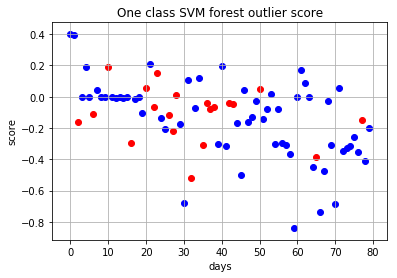

In [173]:
fig = plt.figure()
cls = OneClassSVM(kernel='rbf', gamma=1e-2)
cls.fit(model.graph_embeddings[np.where(labels == 0)[0]][:15])
plt.scatter(np.where(labels==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==1)], c='r', label='outlier')
plt.scatter(np.where(labels==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==0)], c='b', label='normal')
plt.grid()
plt.title("One class SVM forest outlier score")
plt.ylabel('score')
plt.xlabel('days')
fig.savefig('oneclass_svm.pdf', format='pdf')  

### Isolation forest

In [135]:
from sklearn.ensemble import IsolationForest

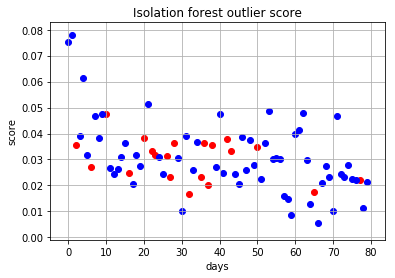

In [174]:
fig = plt.figure()
cls = IsolationForest(n_estimators=1000)
cls.fit(model.graph_embeddings[np.where(labels == 0)[0]][:15])
plt.scatter(np.where(labels==1), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==1)], c='r', label='outlier')
plt.scatter(np.where(labels==0), 
            cls.decision_function(model.graph_embeddings)[np.where(labels==0)], c='b', label='normal')
plt.title("Isolation forest outlier score")
plt.ylabel('score')
plt.xlabel('days')
plt.grid()
fig.savefig('isolation_forest.pdf', format='pdf')

# Всякие разные вопросы, возникшие по ходу 

* можно ли считать AUC для такой задачи, чтобы сравнивать модели?

In [25]:
from sklearn.manifold import TSNE

In [68]:
tsne = TSNE(perplexity=50)
X = tsne.fit_transform(model.graph_embeddings)

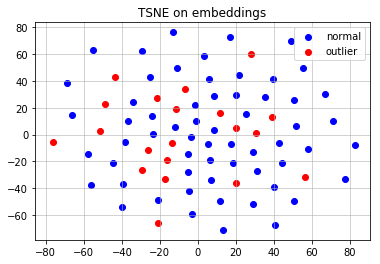

In [69]:
plt.scatter(X[np.where(labels == 0)[0], 0], X[np.where(labels == 0)[0], 1], label='normal', c='b')
plt.scatter(X[np.where(labels == 1)[0], 0], X[np.where(labels == 1)[0], 1], label='outlier', c='r')
plt.title("TSNE on embeddings")
plt.legend()
plt.grid(alpha=0.7)
#plt.scatter(norms[np.where(labels == 1)[0]], label='outlier', c='r')

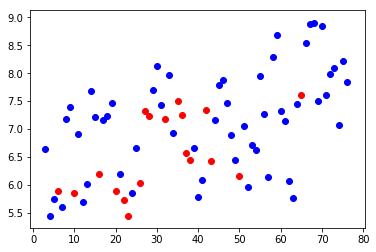

In [70]:
prev_cnt = 3
for i, label in zip(range(prev_cnt, len(labels[prev_cnt:])), labels[prev_cnt:]):
    if label == 0:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i])), c='b')
    else:
        plt.scatter(i, np.linalg.norm(model.graph_embeddings[i] - sum(model.graph_embeddings[i-prev_cnt:i])), c='r')

In [113]:
with model.graph.as_default():
    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    v = sess.run(model.word_embeddings)    
    print(np.linalg.norm(v))

193.41898


In [2]:
from scipy.io import loadmat

In [4]:
import h5py

/Users/Macbook/anaconda/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import hdf5storage
mat = hdf5storage.loadmat('enron/Date_weekend_cropped.mat')

In [9]:
emails = pd.read_csv('../enron/emails.csv')

In [45]:
r,t,y = emails.ix[100]['message'].split('\n')[1:4]

In [46]:
r.split()[2:5]

['16', 'Aug', '2000']

In [47]:
dataset = []
for i in range(len(emails)):
    
    if i%20000 == 0:
        print(i)
    
    DATE, FROM, TO = emails.ix[i]['message'].split('\n')[1:4]
    
    condition1 = DATE[:4] == 'Date' and FROM[:4] == 'From' and TO[:2] == 'To'
    condition2 = DATE[4:] != '' and FROM[4:] != '' and TO[2:] != ''
    
    try:
        dataset.append((' '.join(DATE.split()[2:5]), FROM.split()[1], TO.split()[1]))
    except IndexError:
        pass

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000


In [61]:
temp[3000][0]

'24 Jun 1999'

In [60]:
datetime.datetime.strptime(temp[3000][0], '%d %b %Y')

datetime.datetime(1999, 6, 24, 0, 0)

In [48]:
temp = sorted(dataset, key=lambda x: datetime.datetime.strptime(x[0], '%d %b %Y'))

In [62]:
def check_time(x):
    first = datetime.datetime.strptime(x[0], '%d %b %Y') > datetime.datetime(2000, 6, 24, 0, 0) 
    second = datetime.datetime.strptime(x[0], '%d %b %Y') < datetime.datetime(2002, 3, 24, 0, 0) 
    return first and second
temp1 = [x for x in temp if check_time(x)]

In [67]:
temp1 = np.array(temp1)

In [76]:
time_steps = []
for date in sorted(np.unique(temp1[:, 0]), key=lambda x: datetime.datetime.strptime(x, '%d %b %Y')):
    date_array = []
    for item in temp1:
        if item[0] == date:
            date_array.append(item)
    time_steps.append(date_array)

In [ ]:
sorted(np.unique(temp1[:, 0]), key=lambda x: datetime.datetime.strptime(x, '%d %b %Y'))

In [33]:
def sorting(x):
    print x
    return datetime.datetime.strptime(x[0], '%d %b %Y')

In [99]:
for i, step in enumerate(time_steps):
    f = open('../enron/enron_{0}.txt'.format(i), 'w')
    for line in step:
        f.write(' '.join(line[1:])+'\n')
    f.close()

In [1]:
f = open('../enron/time_steps.txt'.format(i), 'w')
for i in sorted(np.unique(temp1[:, 0]), key=lambda x: datetime.datetime.strptime(x, '%d %b %Y')):
    f.write(i + '\n')
f.close()

NameError: name 'i' is not defined

In [5]:
%ls

GraphAnomaly.ipynb     enron/                 twitter_security_2014/
IAM/                   graphics/
awe/                   mat2text.m
